In [99]:
import pandas as pd
import numpy as np
from collections import Counter

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix

import seaborn as sn
import matplotlib.pyplot as plt

In [16]:
Y_data = pd.read_csv('../data/y_data.csv')
raw_text_data = pd.read_csv('../data/raw_text.csv')
text_data = pd.read_csv('../data/tf_idf_text.csv', header=None)
title_data = pd.read_csv('../data/tf_idf_titles.csv', header=None)

# encode class values as binary
encoder = LabelEncoder().fit(Y_data['uni_label'].values)
dummy_y = encoder.transform(Y_data['uni_label'].values)

## IIa. Build ANN model and perform Stratified kfolds validation

In [3]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
def model_compare(hidden_1_neurons = 512, output_units = 1, input_shape = 1000):

    model = Sequential()
    ## arbitrary use of 8 nodes for now.  Input dimension must be defined for the number of variables being used
    model.add(Dense(hidden_1_neurons, input_shape=(input_shape,), activation = 'relu', kernel_initializer = 'glorot_uniform'))

    model.add(Dense(output_units, activation = 'hard_sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    return model


In [100]:
kfold= StratifiedKFold(n_splits=5, shuffle=True, random_state=2018)
binary_estimator = KerasClassifier(build_fn = model_compare, epochs = 10, batch_size = 32, verbose=0)
scores = cross_validate(binary_estimator, text_data, dummy_y, cv = kfold)['test_score']
np.mean(scores)*100, np.std(scores)*100

(72.68524289131165, 1.2469411980195058)

## IIb. Create training and verification set by splitting the raw text data and fitting TF-IDF to train data ONLY
    - then transform test and train data
    - train model on the training set and test on the verification set

In [59]:
x_train, x_test, train_labels, verification_labels = train_test_split(raw_text_data, dummy_y, test_size=0.2, random_state=2018,stratify=dummy_y)
vectorizer = TfidfVectorizer(max_features=1000).fit(x_train['text'])
train_input = vectorizer.transform(x_train['text']).toarray()
verification_input = vectorizer.transform(x_test['text']).toarray()

In [72]:
model_i = model_compare()

model_i.fit(train_input, train_labels, epochs=10, batch_size=32, verbose=0)
predicted_output = (model_i.predict(verification_input)>0.5).astype('int32')
confusion_matrix_i = confusion_matrix(verification_labels, predicted_output, labels = [1,0], sample_weight=None)

In [101]:
print(classification_report(verification_labels, predicted_output, digits = 4))

              precision    recall  f1-score   support

           0     0.7200    0.7105    0.7152        76
           1     0.7708    0.7789    0.7749        95

    accuracy                         0.7485       171
   macro avg     0.7454    0.7447    0.7451       171
weighted avg     0.7482    0.7485    0.7484       171



([<matplotlib.axis.YTick at 0x7f9e7dc9b290>,
 [Text(0, 0, 'Non-University Subreddit'), Text(0, 1, 'University Subreddit')])

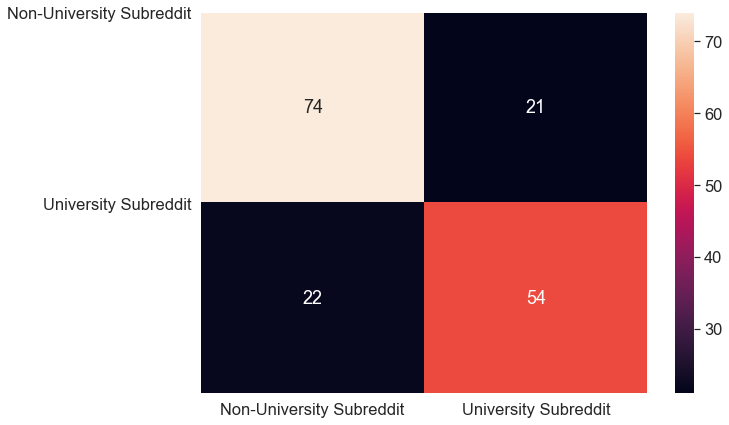

In [150]:
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix_i, annot=True, xticklabels=['Non-University Subreddit','University Subreddit'])

plt.yticks(ticks=[0,1],labels=['Non-University Subreddit','University Subreddit'],rotation=0)

# III. Quick Investigation of mislabeled posts
        Check average char length of the post

In [82]:
counter=0
mislabel_indexs = []
mislabel = []
dict_labels = {1:'uni', 0:'non_uni'}
for j,(i,y) in enumerate(zip(verification_labels,predicted_output.flatten())):
    if i!=y:
        counter+=1
        mislabel_indexs.append(j)
        mislabel.append(dict_labels[i])

x_reset = x_test.reset_index(drop = True)

mislabeled_posts = pd.DataFrame(x_reset.iloc[mislabel_indexs])
mislabeled_posts['REAL_LABELS'] = mislabel

In [87]:
mislabeled_posts['text'].sample()

164    If it has, how do you enable it (im on android). 
Name: text, dtype: object

In [88]:
text_counter = Counter()
for i, text in enumerate(mislabeled_posts['text']):
    text_counter[i] = len(text)

In [89]:
vals =text_counter.values()
np.mean(list(vals))

91.95348837209302